## Using Autoimpute to Compare Imputation Methods
---
This notebook examimes the effect of imputations methods from the autoimpute package. The tutorial includes:
* Generating Data
* Basic Missingness Stats
* Single imputation (mean, norm, linear)
* Predictive imputations (least squares, stochastic, pmm)
* Visualizing each method's effect

### Generating Data
---
In the section below, we generate two variables, $x$ and $y$, that are positively correlated but display heteroscedasticity. This means that $x$ and $y$ get larger (or smaller) together. We then introduce 30% missingness within $y$. $x$ remains completely observed. After generating this data, we peek at the first 10 records and chart the joint scatterplot of the observed features and their respective marginal distributions.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, binom
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# seed to follow along
np.random.seed(654654)

# generate 1500 data points
N = np.arange(1500)

# create correlated, heteroskedastic random variables
a = 0
b = 1
eps = np.array([norm(0, n).rvs() for n in N])
y = (a + b*N + eps) / 100                         
x = (N + norm(10, 10).rvs(len(N))) / 100
 
# 30% missingness created artificially
y[binom(1, 0.3).rvs(len(N)) == 1] = np.nan

# collect results in a dataframe 
data_het_miss = pd.DataFrame({"y": y, "x": x})
data_het_miss.head(10)

,x,y
0,0.295288,0.000000
1,0.086210,0.002255
2,0.227369,0.003869
3,0.194216,0.046370
4,0.094630,0.081440
5,0.292320,NaN
6,0.198131,0.067222
7,0.162378,0.081042
8,0.309530,0.105015
9,0.126771,0.226420


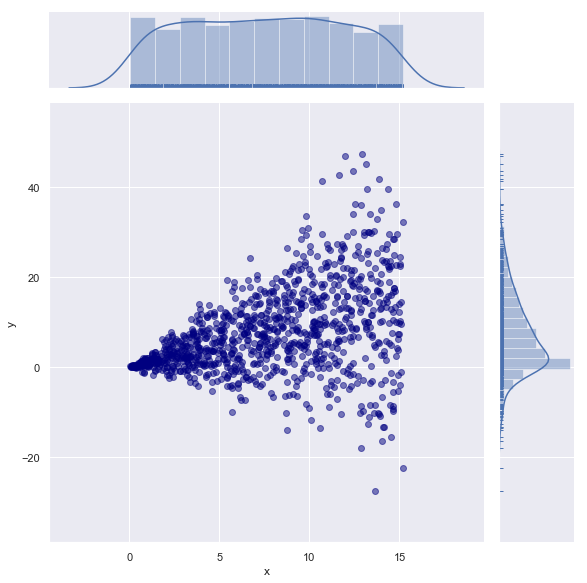

In [2]:
def scatter_dists(data, x="x", y="y", a=0.5, joints_color="navy", 
                  markers="o", marginals=dict(rug=True, kde=True)):
    sns.set()
    joint_kws = dict(facecolor=joints_color, edgecolor=joints_color, marker=markers)
    sns.jointplot(x=x, y=y, data=data, alpha=a, height=8.27,
                  joint_kws=joint_kws, marginal_kws=marginals)
    plt.show()
    
scatter_dists(data_het_miss)

### Exploring Missingness
---
Before imputing any data, we'll quickly explore the missingness within the data to see how much is missing and what the correlation between the two variables is. The output from the methods below confirm the process we used to artifically generate data. The features exhibit modest postive correlation. x is completely observed, while y is ~30% missing. For more information on autoimpute's utility functions, see the [exploring missingness tutorial](https://github.com/kearnz/autoimpute/blob/master/tutorials/exploring_missingness.ipynb).

In [3]:
from autoimpute.utils import proportions, feature_cov, feature_corr, flux

ImportError: cannot import name '_neighbors'

In [4]:
# correlation between x and y
feature_corr(data_het_miss)

,x,y
x,1.000000,0.410591
y,0.410591,1.000000


In [5]:
# proportion missing and observed in x and y
proportions(data_het_miss)

,pobs,poms
x,1.000000,0.000000
y,0.713333,0.286667


In [6]:
# influx, outflux, and avg inbound / outbound
flux(data_het_miss)

,ainb,aout,influx,outflux,pobs
x,0.0,0.286667,0.000000,1.0,1.000000
y,1.0,0.000000,0.167315,0.0,0.713333


### Imputations
---
In this section, we'll turn verbosity on to examine what's happening under the hood when we use each imputation method. We need one strategy per imputation only, because we are simply imputing y. We will set y's predictors to x for each of the predictive methods. Note that by default, x would be used if no predictors are specified at instantiation of each Imputer. We are setting them explicitly here to familiarize ourselves with our options to control the behavior of autoimpute Imputers. For more information about Imputer behavior and instantiation options, reference the imputer properties tutorial (coming soon).

In the first code segment below, we write a helper function to instantiate an imputer with a given strategy. We then fit_transform the data we generated above, and we plot the imputations against the observed. Above each plot, we specify which strategy we are using. We save compare and contrast the imputers at the end of this tutorial.

In [4]:
from autoimpute.imputations import SingleImputer
from autoimpute.imputations import PredictiveImputer

def impute_and_plot(strategy, imputer, data=data_het_miss, **kwargs):
    # instantiate imputer
    # fit transform
    imp = imputer(strategy={"y": strategy}, verbose=True, **kwargs)
    impute = imp.fit_transform(data)
    # set colors for imputed to red
    impute["colors"] = "navy"
    impute.loc[imp.imputed_["y"], "colors"] = "red"
    scatter_dists(impute, joints_color=impute["colors"])
    return imp, impute

#### 1. Mean imputation using observed mean of Y: $\mu_y$
Mean imputation is quick and effective, but it heavily distorts both the relationship between $x$ and $y$ and the distribution of $y$ itself. When we impute with the mean, the distribution of $y$ becomes almost bimodal. The density of the distribution shifts to the mean, creating an artificial peak that would not have existed had we observed $y$. Mean imputation also completely disregards the structure of the data and the relationship between $x$ and $y$. This consequence is obvious, given that mean imputation is a univariate method.

In [5]:
mean_imp, mean_ft = impute_and_plot("mean", SingleImputer)

FITTING IMPUTATION METHODS TO DATA...
Strategies used to fit each column:
-----------------------------------


ValueError: Invalid arguments passed to MeanImputer __init__ method.

#### 2. Imputation with draws from Random Normal distribution of Y: $N ~(\mu_y, \sigma^2_y)$
We get more realistic imputations by taking random draws from a normal distribution with $\mu_y$ and $\sigma^2_y$. The imputations below capture the variance in $y$. That being said, they still fail to take into consideration the relationship between $y$ and $x$, and the imputations don't consider **where $y$ varies** (i.e. at larger values of $x$). 

FITTING IMPUTATION METHODS TO DATA...
Strategies used to fit each column:
-----------------------------------
Column: y, Strategy: norm
PERFORMING IMPUTATIONS ON DATA BASED ON FIT...
----------------------------------------------
Transforming y with strategy 'norm'
Numer of imputations to perform: 430


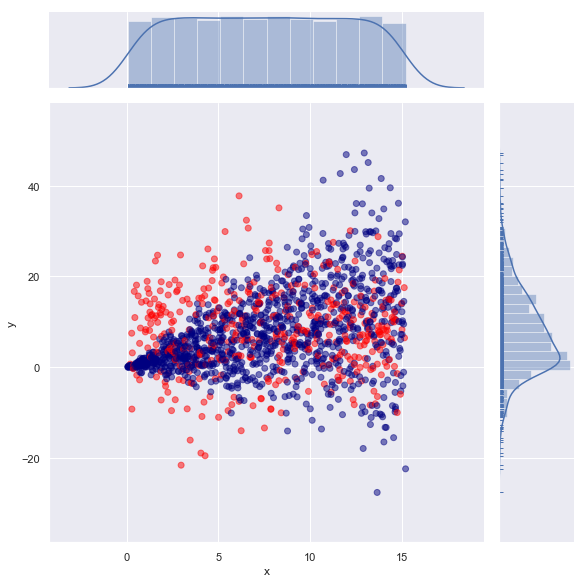

In [9]:
norm_imp, norm_ft = impute_and_plot("norm", SingleImputer)

#### 3. Imputation from Linear Interpolation
Linear interpolation provides the most realistic imputations we've seen so far, but looks can be deceiving. Linear Interpolation **still considers $y$ on its own. Had the data been shuffled, imputations would be scattered incorrectly.** Thus, linear interpolation not only disregards $x$ but is also sensitive to the **row position** of the data in $y$ instead of its actual structure. While this may make sense for time series data, it does not in this situation.

FITTING IMPUTATION METHODS TO DATA...
Strategies used to fit each column:
-----------------------------------
Column: y, Strategy: linear
PERFORMING IMPUTATIONS ON DATA BASED ON FIT...
----------------------------------------------
Transforming y with strategy 'linear'
Numer of imputations to perform: 430


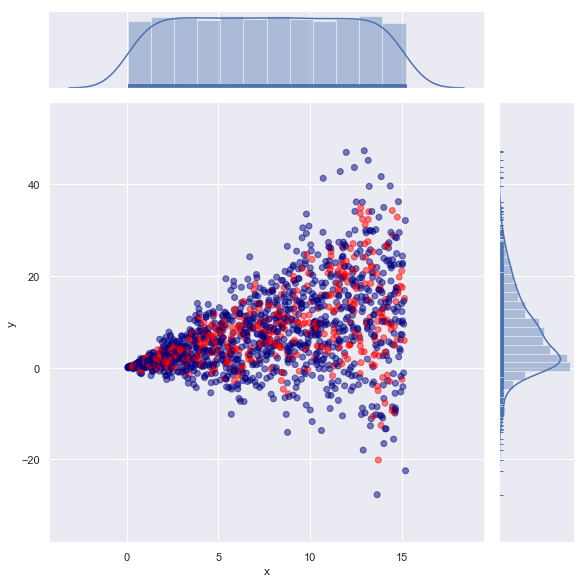

In [10]:
linear_imp, linear_ft = impute_and_plot("linear", SingleImputer)

#### 4. Imputation using predictions from least squares linear regression
As with mean imputation, linear regression imputation does not capture variance whatsoever because all imputations are considered "best fit" point estimates. As a result, all imputations lie along a line. Linear regression imputation does improve upon mean imputation by capturing the correlation between $x$ and $y$, but linear regression imputation artificially deflates variance and inflates the relationship between features.

PREPPING DATAFRAME FOR IMPUTATION ANALYSIS...
---------------------------------------------
Number of numeric columns in X: 2
Number of categorical columns after one-hot encoding: 0
FITTING IMPUTATION METHODS TO DATA...
Strategies & Predictors used to fit each column:
------------------------------------------------
Using single column x to predict y.
Columns used for y:
Numeric: ['x']
Categorical: []
Datetime: []
Missing values in predictor x: 0
Missing values in response y: 430
Number of records before delete: 1500
Number of records after delete: 1070
Column: y, Strategy: least squares
PERFORMING IMPUTATIONS ON DATA BASED ON FIT...
----------------------------------------------
Numer of imputations to perform: 430
Transforming y with strategy 'least squares'
Using single column x to predict y.
Columns used for y:
Numeric: ['x']
Categorical: []
Datetime: []


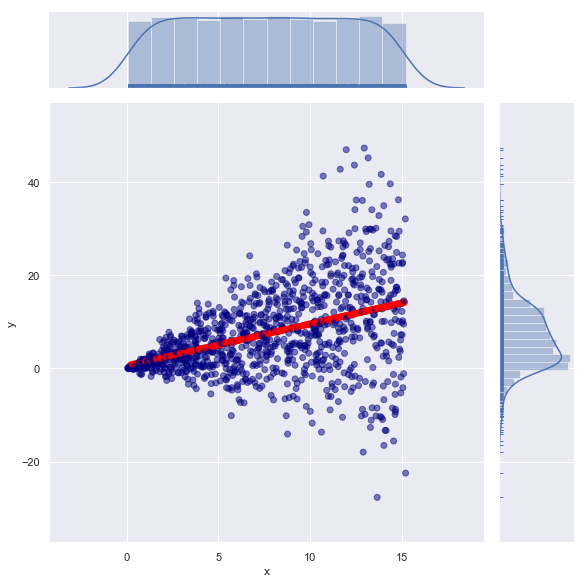

In [6]:
lm_imp, lm_ft = impute_and_plot("least squares", PredictiveImputer, predictors={"y":"x"})

#### 5. Imputation using predictions from least squares linear regression + random draw from distribution of residuals $N ~ (0, \sigma^2)$
Linear regression with stochastic error is the best imputation we've seen yet. As with linear regression, it captures the correlation between the features, and it accurately depicts the variance between them as well. Unfortunately, it has the same problem as norm imputation. It does not consider where and how $y$ varies with $x$. It considers total variance only, and it assumes variance is constant at all points.

PREPPING DATAFRAME FOR IMPUTATION ANALYSIS...
---------------------------------------------
Number of numeric columns in X: 2
Number of categorical columns after one-hot encoding: 0
FITTING IMPUTATION METHODS TO DATA...
Strategies & Predictors used to fit each column:
------------------------------------------------
Using single column x to predict y.
Columns used for y:
Numeric: ['x']
Categorical: []
Datetime: []
Missing values in predictor x: 0
Missing values in response y: 430
Number of records before delete: 1500
Number of records after delete: 1070
Column: y, Strategy: stochastic
PERFORMING IMPUTATIONS ON DATA BASED ON FIT...
----------------------------------------------
Numer of imputations to perform: 430
Transforming y with strategy 'stochastic'
Using single column x to predict y.
Columns used for y:
Numeric: ['x']
Categorical: []
Datetime: []


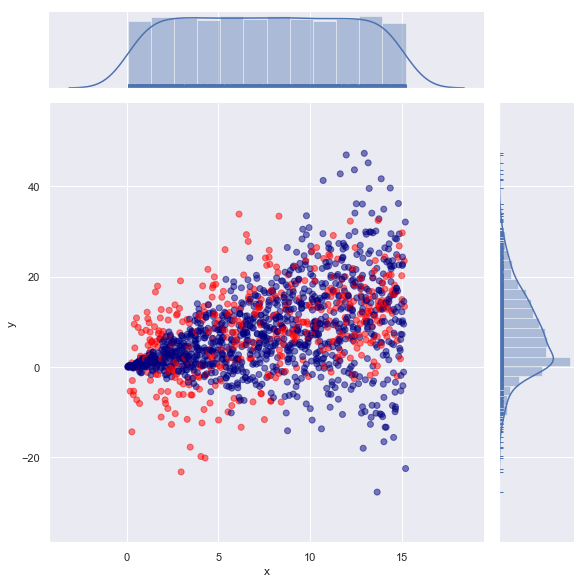

In [7]:
stoch_imp, stoch_ft = impute_and_plot("stochastic", PredictiveImputer, predictors={"y":"x"})

#### 6. Predictive Mean Matching Imputation - Nearest 5 Neighbors
Finally, PMM is **the optimal and most flexible method for our dataset.** PMM is more complex, so let's review its steps:

1. Fit a linear regression on observed data. Keep the predictions $\hat y_{observed}$ and the $\hat \beta$ coefficients handy.
2. Fit a bayesian model on the observed data, using the coefficients from step 1 as inputs to the priors of the bayesian model.
    - Note: passing coefficients to priors is optional
    - We can use uninformative priors instead, but convergence may be much slower
    - Passing coefficients may speed up MCMC methods to generate posterior predictive distributions
    - If the linear model is poor, however, the coefficients may do more harm than good
3. Make a random draw from the **posterior predictive distribution** of $\hat \beta$ to produce a new set of coefficients $\beta^{\star}$
    - This is a random draw using the means and the covariance matrix of the $\hat \beta$s
    - The random draw creates sufficient variability and is the **first step to generalise to multiple imputation**
4. Using the coefficents produced from the random draw, predict missing values for $y$ from the corresonding features $x$
5. For each predicted $y$, find the $n$ closest predictions $y_{pred}$ from the original observed linear regression.
6. Take a random draw from the actual, observed $y$ values that correspond to each $y_{pred}$, and impute.

The steps above summarize predictive mean matching. It borrows ideas from linear models to capture the correlation between features, and it borrows strategies from hot-deck methods like knn by sampling from "near neighbors". As a result, we get realistic imputations, and we obey the **covariance structure** of the dataset. Additionally, we preserve the **heteroskedasticity of the data**. There are downsides to PMM, but they are not in scope for this tutorial.

PREPPING DATAFRAME FOR IMPUTATION ANALYSIS...
---------------------------------------------
Number of numeric columns in X: 2
Number of categorical columns after one-hot encoding: 0
FITTING IMPUTATION METHODS TO DATA...
Strategies & Predictors used to fit each column:
------------------------------------------------
Using single column x to predict y.
Columns used for y:
Numeric: ['x']
Categorical: []
Datetime: []
Missing values in predictor x: 0
Missing values in response y: 430
Number of records before delete: 1500
Number of records after delete: 1070


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Column: y, Strategy: pmm
PERFORMING IMPUTATIONS ON DATA BASED ON FIT...
----------------------------------------------
Numer of imputations to perform: 430
Transforming y with strategy 'bayesian least squares'
Using single column x to predict y.
Columns used for y:
Numeric: ['x']
Categorical: []
Datetime: []


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, beta, alpha]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1681.09draws/s]


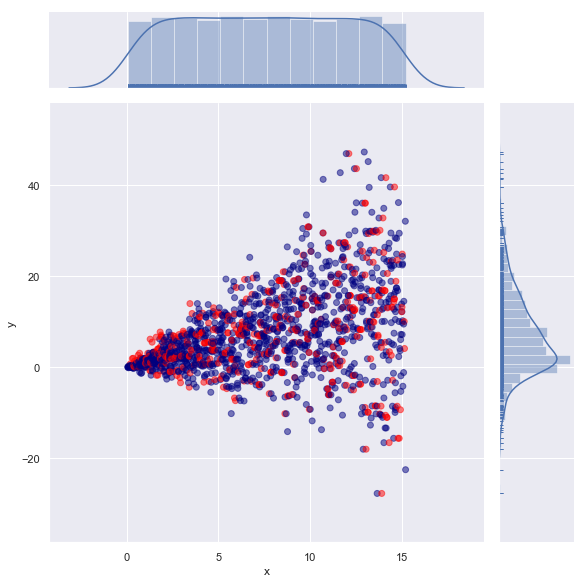

In [10]:
pmm_imp, pmm_ft = impute_and_plot(
    "pmm", PredictiveImputer, predictors={"y":"x"}, imp_kwgs={"pmm":{"fill_value":"random"}}
)

### Impact of each Strategy on Covariance and Correlation
Although we can assess accuracy if we conduct a simulation (as we know the true values of $y$ where $y$ is missing), this assessment is misguided. The goal of imputation is to **preserve the structure of the data**, not correctly guess the true value of the missing points. With real-world data, we often do not have and never will have "true" values. Therefore, accuracy is not the best objective. Instead, we want to preserve the covariance (and thus correlation) between features after imputation takes place. If we preserve the data's structure, we can more safely assume that our imputations are plausible. Now, this objective assumes we are working with data that is **at least Missing at Random (MAR)**, as do all the methods utilized in this tutorial. If data is missing not at random, preservation may actually indicate poor imputation.

In [14]:
def cov_corr(df):
    cov = feature_cov(df)
    corr = feature_corr(df)
    cov_corr_df = pd.concat([cov, corr], axis=1)
    cov_corr_df.columns = columns=["cov_x", "cov_y", "corr_x", "corr_y"]
    return cov_corr_df

#### Observed Only
Because we assume data is missing at random or missing completely at random, we can use the observed points to determine the initial correlation and covariance of the data. We calculate these matrices after using each imputation method. 

In [15]:
cov_corr(data_het_miss)

,cov_x,cov_y,corr_x,corr_y
x,18.782294,16.859482,1.000000,0.410591
y,16.859482,90.140563,0.410591,1.000000


#### 1. Mean Imputation
Mean imputation depresses the covariance and correlation between features. This should make sense intuitively, as mean imputation is univariate. It ignores $x$ all together, and it even ignores variance in $y$. As a result, covariance and correlation drop substantially.

In [16]:
cov_corr(mean_ft)

,cov_x,cov_y,corr_x,corr_y
x,18.782294,12.023207,1.000000,0.346017
y,12.023207,64.283030,0.346017,1.000000


#### 2. Norm Imputation
Norm imutation draws random values from a normal distribution $N ~ (\mu_y,\sigma^2_y)$. Because values are drawn at random, and because draws do not consider $x$ whatsoever, the correlation and covariance drops. This should also make sense intuitively. Random draws should never help correlation or covariance, or else randomness would not be true.

In [17]:
cov_corr(norm_ft)

,cov_x,cov_y,corr_x,corr_y
x,18.782294,12.471649,1.000000,0.305511
y,12.471649,88.725062,0.305511,1.000000


#### 3. Linear Interpolation Imputation
Linear interpoloation does a good job preserving the structure of the data, although it artificially inflates both to a minor degree. This inflation occurs because linear interpolation has no stochastic component.

In [18]:
cov_corr(linear_ft)

,cov_x,cov_y,corr_x,corr_y
x,18.782294,16.995538,1.000000,0.428826
y,16.995538,83.629567,0.428826,1.000000


#### 4. Least Squares Imputation
Least squares imputes using predictions from the line of best fit. There is no stochastic component, and the imputations respect the slope of the fitted line. Therefore, correlation and covariance are artificially inflated to unnaceptable levels.

In [19]:
cov_corr(lm_ft)

,cov_x,cov_y,corr_x,corr_y
x,18.782294,16.929476,1.000000,0.471275
y,16.929476,68.705310,0.471275,1.000000


#### 5. Stochastic Imputation
Stochastic imputation is least squares imputation combined with norm imputation, where the mean and variance of the normal distribution are now the mean and variance of the errors from the regression fit. The stochastic component brings the correlation and covariance back to acceptable levels.

In [20]:
cov_corr(stoch_ft)

,cov_x,cov_y,corr_x,corr_y
x,18.782294,17.857975,1.000000,0.420059
y,17.857975,96.226714,0.420059,1.000000


#### 6. Predictive Mean Matching Imputation
Predictive mean matching does a great job respecting the correlation and covariance of the data. Each measure is a bit lower than the observed metrics, but the difference is simply be related to the random selections of one PMM iteration rather than a character flaw of the imputation method itself. The matrices below confirm the good fit we visualized above.

In [21]:
cov_corr(pmm_ft)

,cov_x,cov_y,corr_x,corr_y
x,18.782294,15.981597,1.000000,0.380024
y,15.981597,94.160862,0.380024,1.000000
